# Ensembler:
This code implements an Ensemble method using a Primary Binary model and then follows it up with a multi-class secondary model to try and seperate normal values from the remaining falsely predicted values. Once the normal values are seperated, the overall accuracy on binary threats will be 100%. This can be done by using evaluation methods such as shap to see what unique characteristics the Normal labels may have compared to the threat labels allowing for the use of certain rule-based methods to be implemented. The accuracy of the combined process is overall better than just using a single model.


The trained models can be found in Models and can be further tuned using the given parameters to give us more optimal results. For Example: Would passing the weights using compute class weights over from the primary model to the secondary yield better results? Or would reducing the amount of threat labels increase prediction on Normal labels further. Or would increasing the number of estimators to 200 achieve a 100% accuracy.

The saved models and encoders are saved in the Models/saved_models folder and then loaded into the Ensembler.

Why can't we use the Random Forest which has a better overall accuracy?
Well it's because in reality we don't actually have the actual labels so there is no way for us to group the threats that have been incorrectly predicted. But in this way we can assume that all threats have been predicted and some normal values are carried over which makes us able to use the predicted labels as a group and pass them into the following model.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNsmote, plot_confusion_matrix, plot_metrics

In [3]:
data = pd.read_csv('Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_24124\1715623287.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [5]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [6]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


# Primary NNsmote:
This is the Neural Network with SMOTE version which detects all the threats accurately but has a larger number of false predictions in the Normal labels.

In [7]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# These settings are redundant as we are reloading an older model but parameters are required for init.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fully_connected_size = 128
save_dir = './saved_models/'
model1 = NNsmote(n_features=n_features, fc_size=fully_connected_size, device=device, save_dir=save_dir)

In [ ]:
# Load trained model.
model1 = model1.load_model('Models/saved_models/PB_epoch_1.joblib')

In [ ]:
# Run on Test Dataset.
model1.test(test_loader)

Testing: 100%|██████████| 3969/3969 [00:12<00:00, 330.25batch/s]

Test Loss: 0.0229, Test Accuracy: 0.9871, Test F1: 0.9876


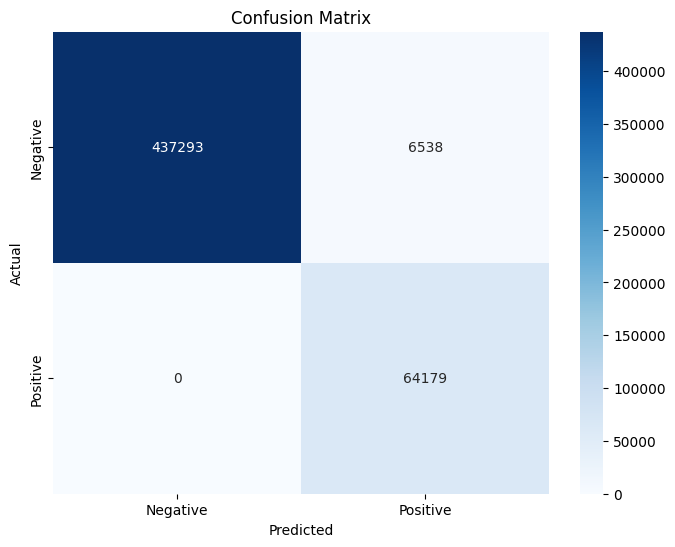

In [14]:
# We use y_pred later to split the data further.
y_pred = np.array(model1.test_predicted)
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [15]:
print(len(test_dataset.tensors[0]))
print(len(y_pred[y_pred==1]))

508010
70717


In [16]:
# Load Secondary model and encoder.
rf2 = joblib.load('./Models/saved_models/SecondaryMulti.joblib')
label_encoder = joblib.load('./Models/saved_models/label_encoder.joblib')

In [17]:
data2 = pd.DataFrame(test_dataset.tensors[0], columns=X_test.columns)
data2['y_pred'] = y_pred
data2['actual'] = test_attack_cat.reset_index(drop=True)

In [ ]:
print(data2['actual'].value_counts(dropna=False))
data2 = data2[data2['y_pred'] == 1]
data2 = data2.reset_index(drop=True)

attack_cat
Normal            443831
Generic            43110
Exploits            8732
Fuzzers             4784
DoS                 3315
Reconnaissance      2850
Analysis             550
Backdoor             477
Shellcode            320
Worms                 41
Name: count, dtype: int64
actual
Normal            443831
Generic            43110
Exploits            8732
Fuzzers             4784
DoS                 3315
Reconnaissance      2850
Analysis             550
Backdoor             477
Shellcode            320
Worms                 41
Name: count, dtype: int64
actual
Generic           43110
Exploits           8732
Normal             6538
Fuzzers            4784
DoS                3315
Reconnaissance     2850
Analysis            550
Backdoor            477
Shellcode           320
Worms                41
Name: count, dtype: int64


In [19]:
actual = label_encoder.transform(data2['actual'])
data2 = data2.drop(columns=['y_pred', 'actual'])
print(len(data2))

70717


In [21]:
y_pred2 = rf2.predict(data2)
print('\nClassification Report (Test Set):')
print(classification_report(actual, y_pred2))
print(y_pred2)


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.69      0.08      0.14       550
           1       0.74      0.06      0.12       477
           2       0.30      0.22      0.26      3315
           3       0.61      0.82      0.70      8732
           4       0.79      0.70      0.74      4784
           5       1.00      0.98      0.99     43110
           6       0.85      0.91      0.88      6538
           7       0.94      0.77      0.85      2850
           8       0.69      0.77      0.73       320
           9       0.33      0.02      0.05        41

    accuracy                           0.88     70717
   macro avg       0.69      0.54      0.55     70717
weighted avg       0.88      0.88      0.87     70717

[5 3 3 ... 2 3 5]


In [ ]:
# The Normal predictions could be optimised a bit more?
y_pred2 = label_encoder.inverse_transform(y_pred2)
actual = label_encoder.inverse_transform(actual)
print('\nClassification Report (Test Set):')
print(classification_report(actual, y_pred2))
categories = label_encoder.classes_
for category in categories:
    actual_category = actual == category
    predicted_category = y_pred2 == category
    accuracy = (actual_category & predicted_category).sum() / actual_category.sum()
    print(f"Accuracy for category '{category}': {accuracy:.4f}")


Classification Report (Test Set):
                precision    recall  f1-score   support

      Analysis       0.69      0.08      0.14       550
      Backdoor       0.74      0.06      0.12       477
           DoS       0.30      0.22      0.26      3315
      Exploits       0.61      0.82      0.70      8732
       Fuzzers       0.79      0.70      0.74      4784
       Generic       1.00      0.98      0.99     43110
        Normal       0.85      0.91      0.88      6538
Reconnaissance       0.94      0.77      0.85      2850
     Shellcode       0.69      0.77      0.73       320
         Worms       0.33      0.02      0.05        41

      accuracy                           0.88     70717
     macro avg       0.69      0.54      0.55     70717
  weighted avg       0.88      0.88      0.87     70717

Accuracy for category 'Analysis': 0.0800
Accuracy for category 'Backdoor': 0.0650
Accuracy for category 'DoS': 0.2244
Accuracy for category 'Exploits': 0.8221
Accuracy for catego

In [23]:
actual_normal = actual[actual == 'Normal']
predicted_normal = y_pred2[y_pred2 == 'Normal']
print(f"Wrong Predictions: {predicted_normal.shape[0] - actual_normal.shape[0]}")

Wrong Predictions: 447
